In [1]:
import os
import cv2
import torch
import random
import numpy as np
import pandas as pd
import torchvision.transforms as transforms

from cv2 import equalizeHist
from PIL import Image, ImageEnhance, ImageOps
from shutil import copyfile
from matplotlib import pyplot as plt

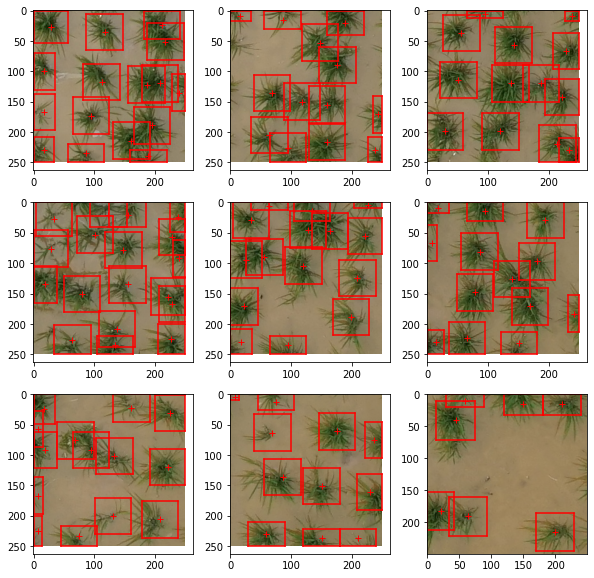

In [2]:
# img = Image.open(r'Train_Dev\training\IMG_170406_035932_0022_RGB4.JPG')
img = Image.open('./Train_Dev/training/DSC080454.JPG')

# with open(r'Train_Dev\train_labels\IMG_170406_035932_0022_RGB4.csv', 'r') as f:
with open(r'Train_Dev\train_labels\DSC080454.csv', 'r') as f:
    lines = f.readlines()

labels = []
for line in lines:
    temp = line.strip().split(',')
    temp[0] = int(temp[0])
    temp[1] = int(temp[1])
    labels.append(temp)

stride = 250

plt.figure(figsize=(10,10))
n = 3 # plot n by n

for x_seg in range(n):
    for y_seg in range(n):

        plt.subplot(n, n, (x_seg * n + y_seg)+1)

        left = stride * x_seg
        right = stride * (x_seg + 1)
        top = stride * y_seg
        bot = stride * (y_seg + 1)

        box = (left, top, right, bot)
        # box = (top, left, bot, right)
        plt.imshow(img.crop(box))

        aerr = 20

        for idx, label in enumerate(labels):
            if label[0] >= left-aerr and label[0] <= right+aerr and label[1] <= bot+aerr and label[1] >= top-aerr:
                xc, yc = label[0]-left, label[1]-top

                line = 30

                xleft = xc-line if xc-line > 0 else 0
                xright = xc+line if xc+line < stride else stride
                ytop = yc-line if yc-line > 0 else 0
                ybot = yc+line if yc+line < stride else stride

                new_xc = (xleft+xright)/2
                new_yc = (ytop+ybot)/2
                plt.plot(new_xc, new_yc, 'r+')
                plt.plot([xleft, xright], [ybot, ybot], 'r-')
                plt.plot([xleft, xright], [ytop, ytop], 'r-')
                plt.plot([xright, xright], [ytop, ybot], 'r-')
                plt.plot([xleft, xleft], [ytop, ybot], 'r-')

In [3]:
def read_label(lpath):

    labels = []

    with open(lpath, 'r') as f:
        lines = f.readlines()
    for line in lines:
        x, y = tuple(line.strip().split(','))
        labels.append((int(x),int(y)))

    return labels

def to_yolo(label, box, out, stride, label_size):
    left, top, right, bot = box
    if label[0] >= left - out and label[0] <= right + out:
        if label[1] >= top - out and label[1] <= bot + out:
            xc, yc = label[0]-left, label[1]-top
            xleft = xc-label_size/2 if xc-label_size/2>0 else 0
            xright = xc+label_size/2 if xc+label_size/2<stride[0] else stride[0]
            ytop = yc-label_size/2 if yc-label_size/2>0 else 0
            ybot = yc+label_size/2 if yc+label_size/2<stride[1] else stride[1]
            
            new_xc = (xleft + xright)/2
            new_yc = (ytop + ybot)/2
            new_w = xright - xleft
            new_h = ybot - ytop

            return [0, new_xc/stride[0], new_yc/stride[1], new_w/stride[0], new_h/stride[1]]

    return None

def count_label(lpath):
    
    with open(lpath, 'r') as f:
        c = len(f.readlines())
    
    return c

In [4]:
# stride: size of each segment
# label_size: width of label (for yolo)
# out: the tolerance distance for label from another segment

def miniRiceField(out_dir = './miniRiceField', in_dir = './Train_Dev', label21=(30, 20), label48 = 60, out = 10, valid = 0.2, contrast=1, normalized=False, gaussianblur=False):

    in_label_dir = os.path.join(in_dir, 'train_labels')
    in_image_dir = os.path.join(in_dir, 'training')

    os.mkdir(out_dir)

    out_21ds_dir = os.path.join(out_dir, 'af21ds')
    out_48ds_dir = os.path.join(out_dir, 'af48ds')
    os.mkdir(out_21ds_dir)
    os.mkdir(out_48ds_dir)

    out_image_21ds_dir = os.path.join(out_21ds_dir, 'images')
    out_label_21ds_dir = os.path.join(out_21ds_dir, 'labels')
    os.mkdir(out_image_21ds_dir)
    os.mkdir(out_label_21ds_dir)

    out_image_48ds_dir = os.path.join(out_48ds_dir, 'images')
    out_label_48ds_dir = os.path.join(out_48ds_dir, 'labels')
    os.mkdir(out_image_48ds_dir)
    os.mkdir(out_label_48ds_dir)

    os.mkdir(os.path.join(out_image_21ds_dir, 'train'))
    os.mkdir(os.path.join(out_image_21ds_dir, 'valid'))
    os.mkdir(os.path.join(out_image_48ds_dir, 'train'))
    os.mkdir(os.path.join(out_image_48ds_dir, 'valid'))

    os.mkdir(os.path.join(out_label_21ds_dir, 'train'))
    os.mkdir(os.path.join(out_label_21ds_dir, 'valid'))
    os.mkdir(os.path.join(out_label_48ds_dir, 'train'))
    os.mkdir(os.path.join(out_label_48ds_dir, 'valid'))

    image_filenames = sorted(os.listdir(in_image_dir))
    label_filenames = sorted(os.listdir(in_label_dir))

    # random shuffle
    c = list(zip(image_filenames, label_filenames))
    np.random.shuffle(c)
    image_filenames, label_filenames = zip(*c)

    cnt_48ds, cnt_21ds = 0, 0
    # total number of 21 and 48
    N_48ds = sum(not 'RGB' in image_filename for image_filename in image_filenames)
    N_21ds = sum('RGB' in image_filename for image_filename in image_filenames)

    for image_filename, label_filename in zip(image_filenames, label_filenames):

        from_image_fp = os.path.join(in_image_dir, image_filename)
        from_label_fp = os.path.join(in_label_dir, label_filename)
        # 21 days image
        if 'RGB' in image_filename:
            stride = (128, 144)
            # fixed: image with more labels should have smaller label size
            if count_label(from_label_fp) >= 1000:
                label_size = label21[1]
            else:
                label_size = label21[0]
            dest_image_dir = out_image_21ds_dir
            dest_label_dir = out_label_21ds_dir
            cnt_21ds += 1
            if cnt_21ds < valid * N_21ds:
                split_dir = 'valid'
            else:
                split_dir = 'train'
        # 48 days image
        else: 
            stride = (250, 250)
            label_size = label48
            dest_image_dir = out_image_48ds_dir
            dest_label_dir = out_label_48ds_dir
            cnt_48ds += 1
            if cnt_48ds < valid * N_48ds:
                split_dir = 'valid'
            else:
                split_dir = 'train'

        img = Image.open(from_image_fp)

        # some transformation
        img = transforms.functional.adjust_contrast(img, contrast)

        if normalized == True:
            arr = transforms.functional.to_tensor(img)
            arr = transforms.functional.normalize(arr, mean=0, std=1)
            img = transforms.functional.to_pil_image(arr)

        if gaussianblur == True:
            img = transforms.functional.gaussian_blur(img, kernel_size=3)

        img_width, img_height = img.size

        labels = read_label(from_label_fp)


        # image(0,1100) stride=250
        # (0, 250) (250, 500) (750, 1000) (850, 1100)
        # edit: fix stride
        x_strides = list(range(0, img_width, stride[0]))
        if img_width % stride[0] != 0:
            x_strides = x_strides[:-1]
            x_strides.append(img_width-stride[0])
        y_strides = list(range(0, img_height, stride[1]))
        if img_height % stride[1] != 0:
            x_strides = x_strides[:-1]
            y_strides.append(img_height-stride[1])

        for x_stride in x_strides:
            for y_stride in y_strides:
                
                out_image_filename = image_filename.split('.')[0] + '_{}_{}.JPG'.format(x_stride, y_stride)
                out_label_filename = label_filename.split('.')[0] + '_{}_{}.txt'.format(x_stride, y_stride)

                out_image_filepath = os.path.join(dest_image_dir, split_dir, out_image_filename)
                out_label_filepath = os.path.join(dest_label_dir, split_dir, out_label_filename)

                left, right = x_stride, x_stride + stride[0]
                top, bot = y_stride, y_stride + stride[1]

                # save cropped image
                box = (left, top, right, bot)
                # ====block this when test====
                img.crop(box).save(out_image_filepath)

                label_crop_yolo = []
                for label in labels:
                    if label[0] >= left - out and label[0] <= right + out:
                        if label[1] >= top - out and label[1] <= bot + out:
                            xc, yc = label[0]-left, label[1]-top
                            xleft = xc-label_size/2 if xc-label_size/2>0 else 0
                            xright = xc+label_size/2 if xc+label_size/2<stride[0] else stride[0]
                            ytop = yc-label_size/2 if yc-label_size/2>0 else 0
                            ybot = yc+label_size/2 if yc+label_size/2<stride[1] else stride[1]
                            
                            new_xc = (xleft + xright)/2
                            new_yc = (ytop + ybot)/2
                            new_w = xright - xleft
                            new_h = ybot - ytop

                            label_crop_yolo.append(
                                [0, new_xc/stride[0], new_yc/stride[1], new_w/stride[0], new_h/stride[1]]
                            )

                # no label exist in the image
                if len(label_crop_yolo) != 0:
                    np.savetxt(out_label_filepath, np.asarray(label_crop_yolo), fmt = '%d %f %f %f %f')
                else:
                    with open(out_label_filepath, 'w') as f:
                        f.write('')

In [8]:
miniRiceField(out_dir='miniRiceField_5' , out=5)

In [7]:
def DrawLabel(img_fp, label_fp, contrast=1):
    
    img = Image.open(img_fp)
    img = transforms.functional.adjust_contrast(img, contrast)
    plt.figure()
    plt.imshow(img)
    plt.xlim(0, img.size[0])
    plt.ylim(0, img.size[1])
    
    with open(label_fp, 'r') as f:
        lines = f.readlines()

    for line in lines:
        if label_fp.endswith('.txt'):
            c, x, y ,w, h = line.strip().split()
            x = int(float(x) * img.size[0])
            y = int(float(y) * img.size[1])
            w = int(float(w) * img.size[0])
            h = int(float(h) * img.size[1])
            plt.plot(x,y,'r+')    
            plt.plot([x-w/2, x-w/2], [y-h/2, y+h/2], 'r-')
            plt.plot([x+w/2, x+w/2], [y-h/2, y+h/2], 'r-')
            plt.plot([x-w/2, x+w/2], [y-h/2, y-h/2], 'r-')
            plt.plot([x-w/2, x+w/2], [y+h/2, y+h/2], 'r-')
        else: # csv
            x, y = line.strip.split()
            x, y = int(x), int(y)
            plt.plot(x,y,'r+')


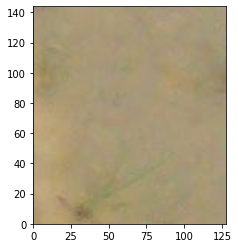

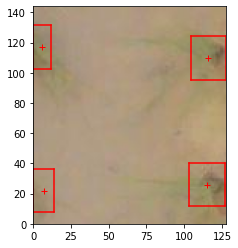

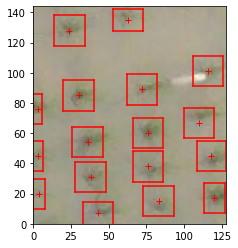

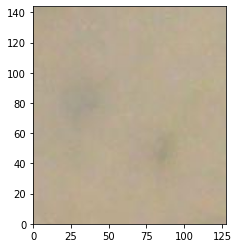

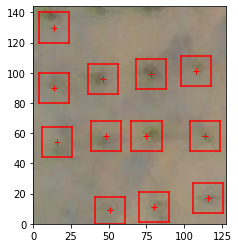

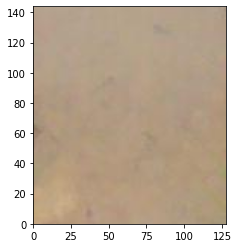

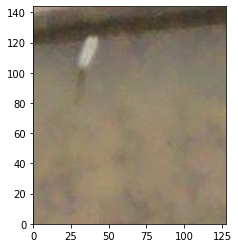

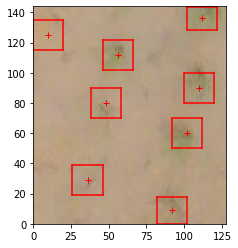

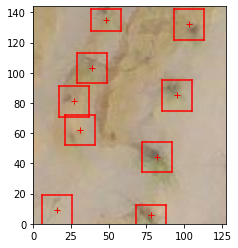

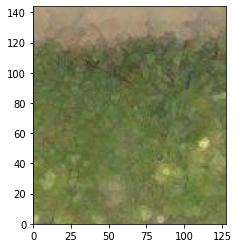

In [11]:
train21id = r'miniRiceField_5\af21ds\images\train'
valid21id = r'miniRiceField_5\af21ds\images\valid'
train21ld = r'miniRiceField_5\af21ds\labels\train'
valid21ld = r'miniRiceField_5\af21ds\labels\valid'

train48id = r'miniRiceField_5\af48ds\images\train'
valid48id = r'miniRiceField_5\af48ds\images\valid'
train48ld = r'miniRiceField_5\af48ds\labels\train'
valid48ld = r'miniRiceField_5\af48ds\labels\valid'

fpis21 = [os.path.join(train21id, f) for f in os.listdir(train21id)]
fpis48 = [os.path.join(train48id, f) for f in os.listdir(train48id)]

fpls21 = [os.path.join(train21ld, f) for f in os.listdir(train21ld)]
fpls48 = [os.path.join(train48ld, f) for f in os.listdir(train48ld)]

for i in np.random.randint(0,len(fpis21), size=10):
    DrawLabel(fpis21[i], fpls21[i])


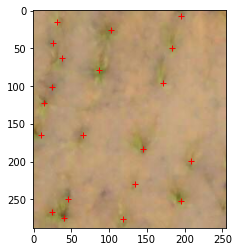

In [24]:
img = Image.open(r'miniRiceField_3\af21ds\images\train\IMG_170406_035932_0022_RGB4_0_1152.JPG')
# img = ImageOps.flip(img)
img = ImageOps.mirror(img)
plt.imshow(img)
with open(r'miniRiceField_3\af21ds\labels\train\IMG_170406_035932_0022_RGB4_0_1152.txt') as f:
    lines = f.readlines()
for line in lines:
    c, x, y, w, h = line.strip().split()
    plt.plot(img.size[0] - float(x)*img.size[0], float(y)*img.size[1], 'r+')


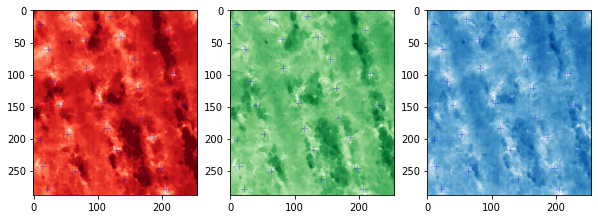

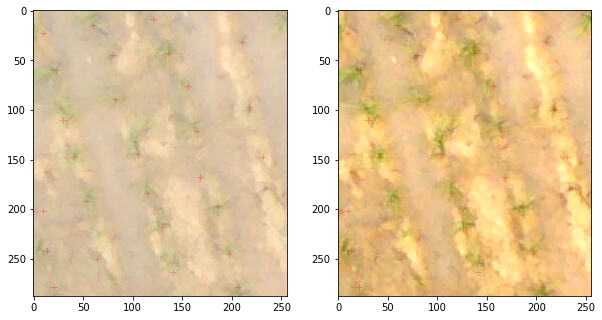

In [128]:
t = transforms.Compose([
    # transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(0,1),
    transforms.ToPILImage(),
])

fig, ax = plt.subplots(1,3, figsize=(10,10))

# ax[0].imshow(img)

img_r = Image.fromarray(np.array(img)[:,:,0])
img_g = Image.fromarray(np.array(img)[:,:,1])
img_b = Image.fromarray(np.array(img)[:,:,2])

# ax[1].imshow(transforms.functional.adjust_saturation(t(img), 2))
# ax[1].imshow(transforms.functional.gaussian_blur(t(img_g), kernel_size = 3, sigma= 6))
img_r = transforms.functional.adjust_contrast(img_r, 1.5)
img_b = transforms.functional.adjust_contrast(img_b, 1.5)
ax[0].imshow(t(img_r), cmap='Reds')
ax[1].imshow(t(img_g), cmap='Greens')
ax[2].imshow(t(img_b), cmap='Blues')
# ax[1].imshow(t(img))
# help(TF.Resize)

for line in lines:
    c, x, y, w, h = line.strip().split()
    for i in range(3):
        ax[i].plot(img.size[0] - float(x)*img.size[0], float(y)*img.size[1], 'b+', alpha=0.3)

a = transforms.functional.adjust_contrast(img, 1.9)
# a = transforms.functional.gaussian_blur(a, kernel_size=3, sigma=1)

fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(img)
ax[1].imshow(a)

for line in lines:
    c, x, y, w, h = line.strip().split()
    for i in range(2):
        ax[i].plot(img.size[0] - float(x)*img.size[0], float(y)*img.size[1], 'r+', alpha=0.3)

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


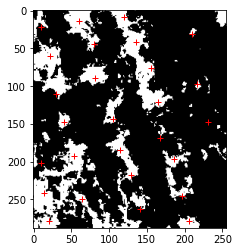

In [97]:
cond1 = (np.array(t(img_r)) < 210) & (np.array(t(img_b)) < 160)

mask_r = np.where(np.array(t(img_r)) < 200, 1, 0)
mask_b = np.where(np.array(t(img_b)) < 150, 1, 0)
mask = np.where(cond1==True, 1, 0)
print(mask_r)
plt.imshow(mask, cmap='gray')

for line in lines:
    c, x, y, w, h = line.strip().split()
    plt.plot(img.size[0] - float(x)*img.size[0], float(y)*img.size[1], 'r+')

2112
255
1225


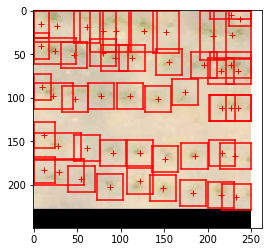

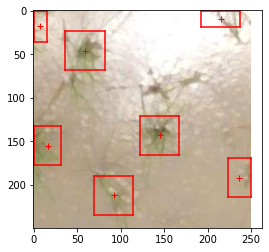

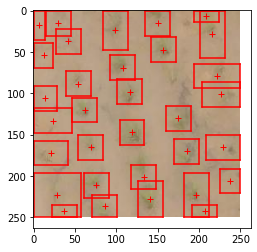

In [25]:
p1 = r'miniRiceField\af21ds\images\valid\IMG_170406_040009_0053_RGB1_1000_1500.JPG'
# p1 = r'miniRiceField\af21ds\images\train\IMG_170406_040105_0099_RGB4_1500_1000.JPG'
p2 = r'miniRiceField\af21ds\images\train\IMG_170406_040355_0241_RGB4_250_500.JPG'
p3 = r'miniRiceField\af21ds\images\train\IMG_170406_035939_0028_RGB3_250_1000.JPG'


plab1 = p1[:21] + 'labels' + p1[27:].split('.')[0] + '.txt'
plab2 = p2[:21] + 'labels' + p2[27:].split('.')[0] + '.txt'
plab3 = p3[:21] + 'labels' + p3[27:].split('.')[0] + '.txt'

# if 'RGB' in p:
#     stride = (256, 288)
# else:
#     stride = (250,250)

plab1o = r'Train_Dev\train_labels\IMG_170406_040009_0053_RGB1.csv'
plab2o = r'Train_Dev\train_labels\IMG_170406_040355_0241_RGB4.csv'
plab3o = r'Train_Dev\train_labels\IMG_170406_035939_0028_RGB3.csv'
pc1 = count_label(plab1o)
pc2 = count_label(plab2o)
pc3 = count_label(plab3o)

img = Image.open(p1)

enhancer = ImageEnhance.Brightness(img)
factor = 1.4
img = enhancer.enhance(factor)

plt.imshow(img)

with open(plab1, 'r') as f:

    lines = f.readlines()

for line in lines:
    c, x, y, w, h = line.strip().split()

    x,y,w,h = 250*float(x), 250*float(y), 250*float(w), 250*float(h)
    plt.plot(x, y, 'r+')

    if w == 60:
        w = 30

    if h == 60:
        h = 30

    plt.plot([x-w/2, x-w/2], [y-h/2, y+h/2], 'r-')
    plt.plot([x+w/2, x+w/2], [y-h/2, y+h/2], 'r-')
    plt.plot([x-w/2, x+w/2], [y-h/2, y-h/2], 'r-')
    plt.plot([x-w/2, x+w/2], [y+h/2, y+h/2], 'r-')

#=======================
img = Image.open(p2)
plt.figure()
plt.imshow(img)


with open(plab2, 'r') as f:

    lines = f.readlines()

for line in lines:
    c, x, y, w, h = line.strip().split()

    x,y,w,h = 250*float(x), 250*float(y), 250*float(w), 250*float(h)
    plt.plot(x, y, 'r+')

    if w == 60:
        w = 45

    if h == 60:
        h = 45

    plt.plot([x-w/2, x-w/2], [y-h/2, y+h/2], 'r-')
    plt.plot([x+w/2, x+w/2], [y-h/2, y+h/2], 'r-')
    plt.plot([x-w/2, x+w/2], [y-h/2, y-h/2], 'r-')
    plt.plot([x-w/2, x+w/2], [y+h/2, y+h/2], 'r-')
#===========
img = Image.open(p3)
plt.figure()
plt.imshow(img)


with open(plab3, 'r') as f:

    lines = f.readlines()

for line in lines:
    c, x, y, w, h = line.strip().split()

    x,y,w,h = 250*float(x), 250*float(y), 250*float(w), 250*float(h)
    plt.plot(x, y, 'r+')

    if w == 60:
        w = 30

    if h == 60:
        h = 30

    plt.plot([x-w/2, x-w/2], [y-h/2, y+h/2], 'r-')
    plt.plot([x+w/2, x+w/2], [y-h/2, y+h/2], 'r-')
    plt.plot([x-w/2, x+w/2], [y-h/2, y-h/2], 'r-')
    plt.plot([x-w/2, x+w/2], [y+h/2, y+h/2], 'r-')

print(pc1)
print(pc2)
print(pc3)

In [17]:
root = r'Train_Dev\train_labels'

cnt = [[] for i in range(4)]

for fname in os.listdir(root):

    with open(os.path.join(root, fname), 'r') as f:
        lines = f.readlines()

    if 'RGB' in fname:
        idx = int(fname.split('.')[0][-1])

        cnt[idx-1].append(len(lines))

for idx, c in enumerate(cnt):
    print('{}: {}'.format(idx+1, c))



1: [2112, 2287, 2561]
2: [4007, 269, 299, 267]
3: [1153, 1225, 1987, 2254, 254]
4: [1140, 2544, 2046, 2161, 309, 322, 255]
